# Convolutional Variational Autoencoder Training for L1Trigger

## Packages

In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc

import keras_tuner
from keras_tuner import Hyperband

import joblib

## Read input files

All input files are already sorted in Calo regions (i, j) ~ (18, 14)<br>
Where i = 0 -> 17 corresponds to GCT_Phi = 0 -> 17<br>
Where j = 0 -> 13 corresponds to RCT_Eta = 4 -> 17

Keep this ordering as is when feeding into neural nets. Also keep this in mind when generating/preparing new samples.

### Backgrounds

In [2]:
ZeroBias = np.concatenate((h5py.File('bkg/ZeroBias_0.h5', 'r')['CaloRegions'][()],
                           h5py.File('bkg/ZeroBias_1.h5', 'r')['CaloRegions'][()],
                           h5py.File('bkg/ZeroBias_2.h5', 'r')['CaloRegions'][()]))
ZeroBias = ZeroBias.astype(dtype = 'float32').reshape(ZeroBias.shape[0], 18, 14, 1)
ZeroBias.shape

(315766, 18, 14, 1)

In [3]:
#QCD = np.concatenate((h5py.File('bkg/110X/QCD_0.h5', 'r')['CaloRegions'][()],
#                      h5py.File('bkg/110X/QCD_1.h5', 'r')['CaloRegions'][()],
#                      h5py.File('bkg/110X/QCD_2.h5', 'r')['CaloRegions'][()]))
QCD = h5py.File('bkg/110X/QCD_0.h5', 'r')['CaloRegions'][()]
QCD = QCD.astype(dtype = 'float32').reshape(QCD.shape[0], 18, 14, 1)
QCD.shape

(2400000, 18, 14, 1)

In [4]:
QCD = QCD[:100000, :, :, :]
QCD.shape

(100000, 18, 14, 1)

In [5]:
SingleNeutrino_E10 = np.concatenate((h5py.File('bkg/120X/SingleNeutrino_E-10_0.h5', 'r')['CaloRegions'][()],
                                     h5py.File('bkg/120X/SingleNeutrino_E-10_1.h5', 'r')['CaloRegions'][()],
                                     h5py.File('bkg/120X/SingleNeutrino_E-10_2.h5', 'r')['CaloRegions'][()]))
SingleNeutrino_E10 = SingleNeutrino_E10.astype(dtype = 'float32').reshape(SingleNeutrino_E10.shape[0], 18, 14, 1)
SingleNeutrino_E10.shape

(976000, 18, 14, 1)

In [6]:
SingleNeutrino_E10 = SingleNeutrino_E10[:100000, :, :, :]
SingleNeutrino_E10.shape

(100000, 18, 14, 1)

In [7]:
SingleNeutrino_Pt2To20 = np.concatenate((h5py.File('bkg/120X/SingleNeutrino_Pt-2To20_0.h5', 'r')['CaloRegions'][()],
                                         h5py.File('bkg/120X/SingleNeutrino_Pt-2To20_1.h5', 'r')['CaloRegions'][()],
                                         h5py.File('bkg/120X/SingleNeutrino_Pt-2To20_2.h5', 'r')['CaloRegions'][()]))
SingleNeutrino_Pt2To20 = SingleNeutrino_Pt2To20.astype(dtype = 'float32').reshape(SingleNeutrino_Pt2To20.shape[0], 18, 14, 1)
SingleNeutrino_Pt2To20.shape

(995000, 18, 14, 1)

In [8]:
SingleNeutrino_Pt2To20 = SingleNeutrino_Pt2To20[:100000, :, :, :]
SingleNeutrino_Pt2To20.shape

(100000, 18, 14, 1)

### Signals

In [9]:
signal_files = []
signal_files.append('sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5')#i=0
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5')
signal_files.append('sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5')
signal_files.append('sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5')
signal_files.append('sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5')#i=10
signal_files.append('sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-9000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')#i=20
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-15000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-60_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5')#i=30
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV.h5')
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-350_TuneCP5_14TeV.h5')#i=40
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-600_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/TprimeBToTH_M-650_LH_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VBFHToInvisible_M125_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VBFHToTauTau_M125_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VectorZPrimeGammaToQQGamma_M-10_GPt-75_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5')#i=48

signals = []
for i in range(len(signal_files)):
    signals.append(h5py.File(signal_files[i], 'r')['CaloRegions'][()].astype(dtype = 'float32'))
    signals[i] = signals[i].reshape(signals[i].shape[0], 18, 14, 1)
    print(str(i) + ': ' + str(signals[i].shape))

0: (50000, 18, 14, 1)
1: (39851, 18, 14, 1)
2: (40000, 18, 14, 1)
3: (13000, 18, 14, 1)
4: (40000, 18, 14, 1)
5: (300000, 18, 14, 1)
6: (30000, 18, 14, 1)
7: (291000, 18, 14, 1)
8: (1854, 18, 14, 1)
9: (38023, 18, 14, 1)
10: (6285, 18, 14, 1)
11: (50000, 18, 14, 1)
12: (50000, 18, 14, 1)
13: (50000, 18, 14, 1)
14: (300000, 18, 14, 1)
15: (100000, 18, 14, 1)
16: (100000, 18, 14, 1)
17: (39987, 18, 14, 1)
18: (39985, 18, 14, 1)
19: (35302, 18, 14, 1)
20: (31255, 18, 14, 1)
21: (33454, 18, 14, 1)
22: (40000, 18, 14, 1)
23: (34144, 18, 14, 1)
24: (34533, 18, 14, 1)
25: (29768, 18, 14, 1)
26: (18805, 18, 14, 1)
27: (39229, 18, 14, 1)
28: (30055, 18, 14, 1)
29: (38482, 18, 14, 1)
30: (32293, 18, 14, 1)
31: (40000, 18, 14, 1)
32: (33214, 18, 14, 1)
33: (29860, 18, 14, 1)
34: (1420, 18, 14, 1)
35: (37639, 18, 14, 1)
36: (27488, 18, 14, 1)
37: (32150, 18, 14, 1)
38: (41783, 18, 14, 1)
39: (500000, 18, 14, 1)
40: (178468, 18, 14, 1)
41: (36472, 18, 14, 1)
42: (98476, 18, 14, 1)
43: (100000, 18, 

## Create overlaid samples (ZB + signals) for test

In [10]:
#Overlay signal events on top of ZB before testing
#Simple addition tower by tower: overlaid signal = ZB + signal
#ZB is chosen at random for each signal event before overlaying them
np.random.seed(0)
signals_overlaid = []
for i in range(len(signals)):
    signals_overlaid.append(np.empty((signals[i].shape[0], 18, 14, 1)))
    ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = signals[i].shape[0])
    for j in range(signals[i].shape[0]):
        signals_overlaid[i][j, :, :, 0] = ZeroBias[ZB_random_event[j], :, :, 0] + signals[i][j, :, :, 0]

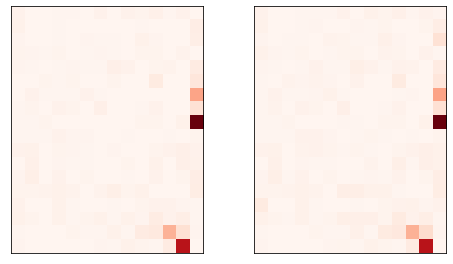

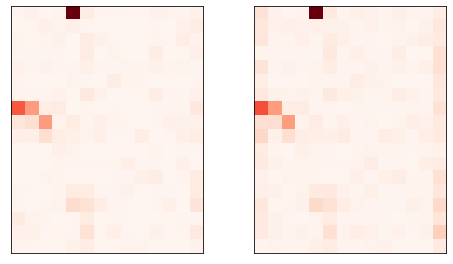

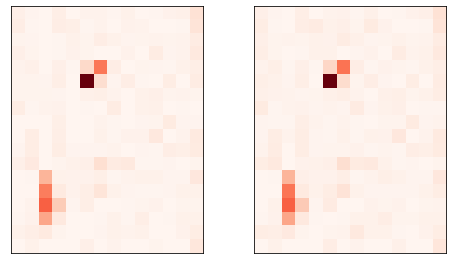

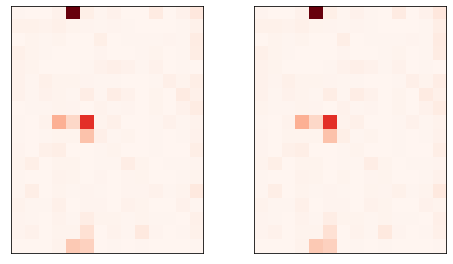

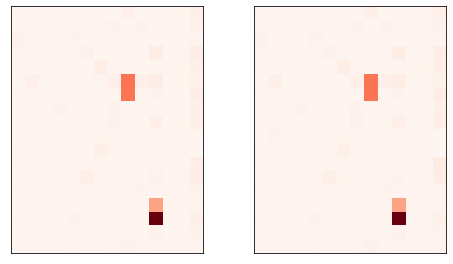

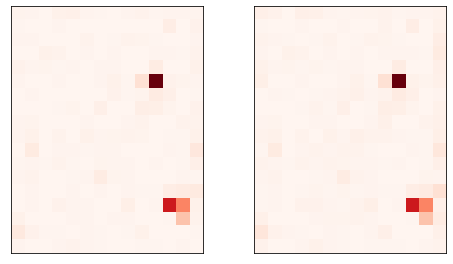

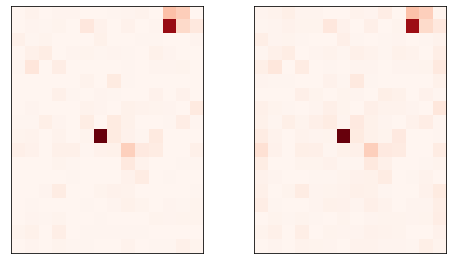

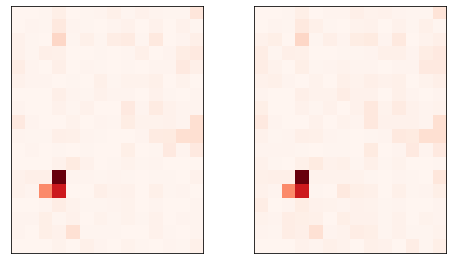

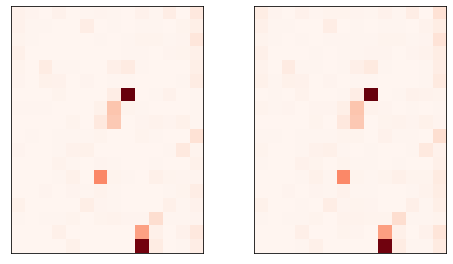

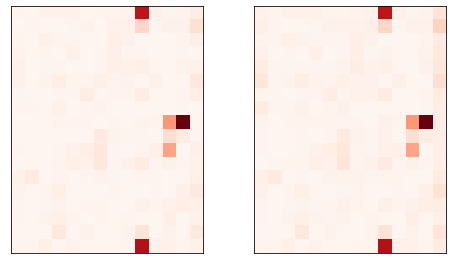

In [11]:
#Plot and compare signals before and after the overlay
n = 12
for i in range(110, 120):
    plt.figure(figsize = (8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(signals[n][i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(signals_overlaid[n][i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()

In [12]:
#Partition the whole training set into train/val/test sets
X = ZeroBias

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

## Convolutional variational autoencoder

### Create model

In [25]:
def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tf.keras.backend.random_normal(shape = tf.keras.backend.shape(mu), mean = 0.0, stddev = 1.0)
    random_sample = mu + tf.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

In [26]:
latent_dim = 3
encoder_inputs = tf.keras.Input(shape = (18, 14, 1))

encoding = layers.Conv2D(20, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_inputs)
encoding = layers.MaxPooling2D((2, 2), padding = 'same')(encoding)
encoding = layers.Conv2D(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)
encoding = layers.Flatten()(encoding)
#encoding = layers.Dense(latent_dim + latent_dim)(encoding)

z_mean = layers.Dense(latent_dim, name = 'z_mean')(encoding)
z_log_var = layers.Dense(latent_dim, name = 'z_log_var')(encoding)

encoder_mu_log_var_model = tf.keras.Model(encoder_inputs, (z_mean, z_log_var))

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_inputs, z, name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 18, 14, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 18, 14, 20)   200         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 7, 20)     0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 9, 7, 10)     1810        max_pooling2d_2[0][0]            
____________________________________________________________________________________________

In [27]:
latent_inputs = tf.keras.Input(shape = (latent_dim,))

decoding = layers.Dense(9 * 7 * 10)(latent_inputs)
decoding = layers.Reshape((9, 7, 10))(decoding)
decoding = layers.Conv2DTranspose(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)
decoding = layers.UpSampling2D((2, 2))(decoding)
decoding = layers.Conv2DTranspose(20, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)

decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(decoding)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 630)               2520      
_________________________________________________________________
reshape_1 (Reshape)          (None, 9, 7, 10)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 9, 7, 10)          910       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 18, 14, 10)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 18, 14, 20)        1820      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 18, 14, 1)         181 

In [28]:
vae_input = layers.Input(shape=(18, 14, 1), name = "VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
model = tf.keras.models.Model(vae_input, vae_decoder_output, name = "VAE")
model.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 18, 14, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 3)                 5796      
_________________________________________________________________
decoder (Functional)         (None, 18, 14, 1)         5431      
Total params: 11,227
Trainable params: 11,227
Non-trainable params: 0
_________________________________________________________________


In [29]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1.
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true - y_predict), axis = [1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis = 1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis = 1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [30]:
model.compile(optimizer = 'adam', loss = loss_func(z_mean, z_log_var))

### Training

In [31]:
history = model.fit(X_train, X_train,
                    epochs = 20,
                    validation_data = (X_val, X_val),
                    batch_size = 1024,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
                    ])

Epoch 1/20


2022-03-30 17:00:48.822362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


216/216 [==============================] - ETA: 0s - loss: 97.3583

2022-03-30 17:01:02.350680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


216/216 [==============================] - 15s 66ms/step - loss: 97.3583 - val_loss: 96.5832
Epoch 2/20
216/216 [==============================] - 13s 62ms/step - loss: 97.0602 - val_loss: 96.4995
Epoch 3/20
216/216 [==============================] - 13s 62ms/step - loss: 97.0389 - val_loss: 96.4936
Epoch 4/20
216/216 [==============================] - 13s 62ms/step - loss: 97.0350 - val_loss: 96.4914
Epoch 5/20
216/216 [==============================] - 13s 61ms/step - loss: 97.0335 - val_loss: 96.4902
Epoch 6/20
216/216 [==============================] - 13s 62ms/step - loss: 97.0324 - val_loss: 96.4892
Epoch 7/20
216/216 [==============================] - 14s 63ms/step - loss: 97.0314 - val_loss: 96.4883
Epoch 8/20
216/216 [==============================] - 13s 62ms/step - loss: 97.0304 - val_loss: 96.4870
Epoch 9/20
216/216 [==============================] - 14s 63ms/step - loss: 97.0292 - val_loss: 96.4862
Epoch 10/20
216/216 [==============================] - 13s 62ms/step - loss

Text(0, 0.5, 'Loss')

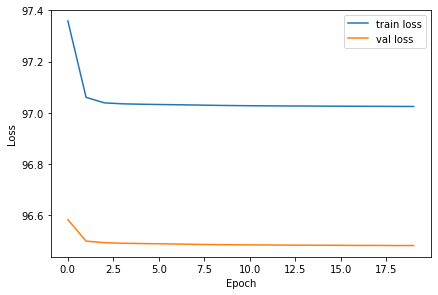

In [32]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [33]:
X_train_predict = model.predict(X_train)
X_test_predict = model.predict(X_test)
signals_overlaid_predict = []
for i in range(len(signals_overlaid)):
    signals_overlaid_predict.append(model.predict(signals_overlaid[i]))

2022-03-30 17:36:55.412894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 17:37:36.279871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [34]:
QCD_predict = model.predict(QCD)
SingleNeutrino_E10_predict = model.predict(SingleNeutrino_E10)
SingleNeutrino_Pt2To20_predict = model.predict(SingleNeutrino_Pt2To20)

## Evaluate performance of the trained model

### Compute and plot loss distributions

In [36]:
X_train_mse = np.mean((X_train_predict - X_train)**2, axis = (1, 2))
X_test_mse = np.mean((X_test_predict - X_test)**2, axis = (1, 2))

signals_overlaid_mse = []
for i in range(len(signals_overlaid)):
    signals_overlaid_mse.append(np.mean((signals_overlaid_predict[i] - signals_overlaid[i])**2, axis = (1, 2)))

In [37]:
QCD_mse = np.mean((QCD_predict - QCD)**2, axis = (1, 2))
SingleNeutrino_E10_mse = np.mean((SingleNeutrino_E10_predict - SingleNeutrino_E10)**2, axis = (1, 2))
SingleNeutrino_Pt2To20_mse = np.mean((SingleNeutrino_Pt2To20_predict - SingleNeutrino_Pt2To20)**2, axis = (1, 2))

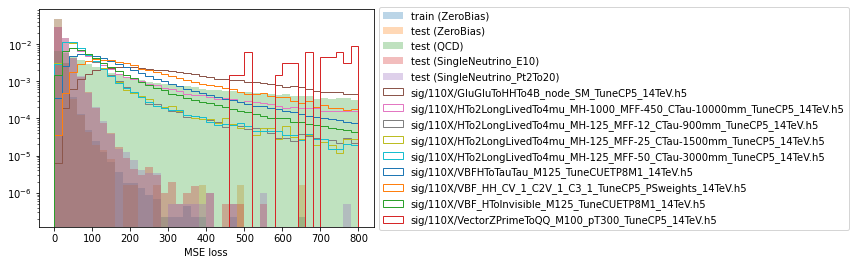

In [38]:
nbins = 40
rmin = 0
rmax = 800
plt.hist(X_train_mse, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZeroBias)', log = True, range = (rmin, rmax))
plt.hist(X_test_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax))
plt.hist(QCD_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (QCD)', range = (rmin, rmax))
plt.hist(SingleNeutrino_E10_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (SingleNeutrino_E10)', range = (rmin, rmax))
plt.hist(SingleNeutrino_Pt2To20_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (SingleNeutrino_Pt2To20)', range = (rmin, rmax))
#for i in range(len(signals_overlaid)):
for i in range(9):
    plt.hist(signals_overlaid_mse[i], density = 1, bins = nbins, label = signal_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("MSE loss")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

### Plot and compare the original and reconstructed inputs

MSE loss = [5.8803606]


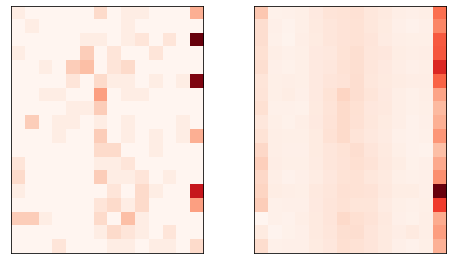

MSE loss = [11.377488]


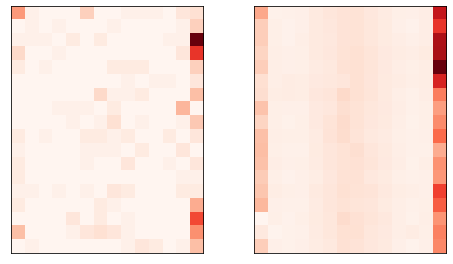

MSE loss = [2.419082]


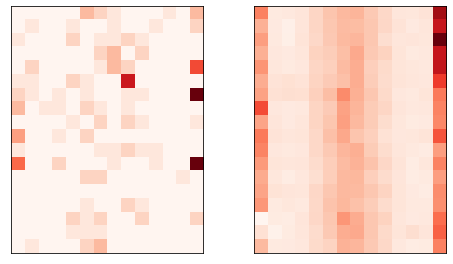

MSE loss = [0.3349852]


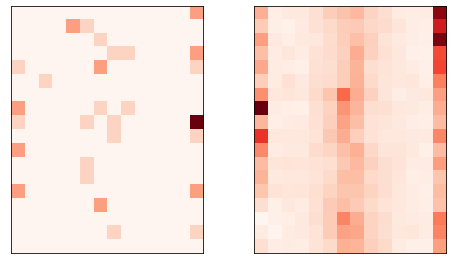

MSE loss = [1.3451409]


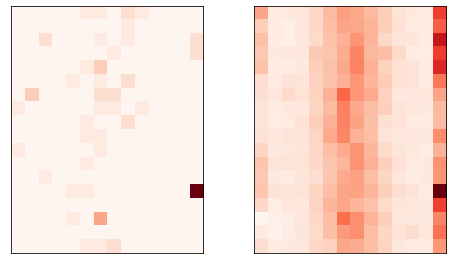

MSE loss = [11.360737]


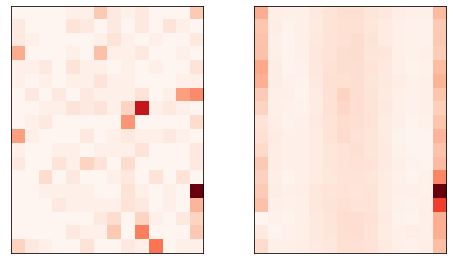

MSE loss = [33.568012]


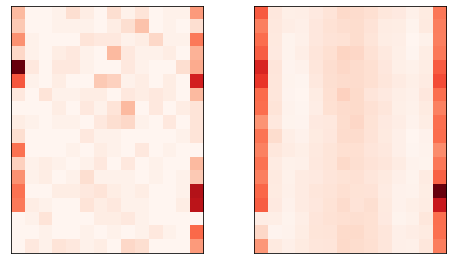

MSE loss = [9.204169]


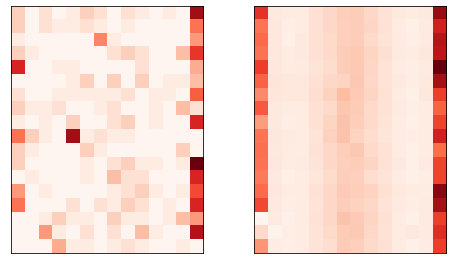

MSE loss = [6.0660424]


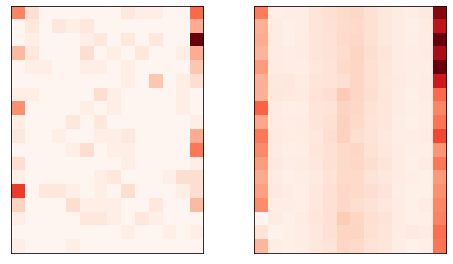

MSE loss = [3.8148606]


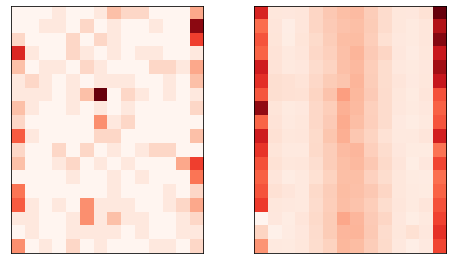

In [39]:
#Original vs Reconstructed for ZB test
for i in range(140,150):
    plt.figure(figsize=(8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(X_test[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(X_test_predict[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print('MSE loss = ' + str(X_test_mse[i]))
    
    plt.show()

MSE loss = [487.62797904]


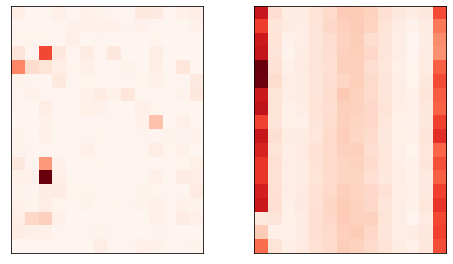

MSE loss = [399.08093354]


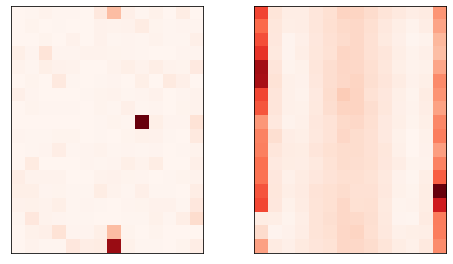

MSE loss = [1236.37797774]


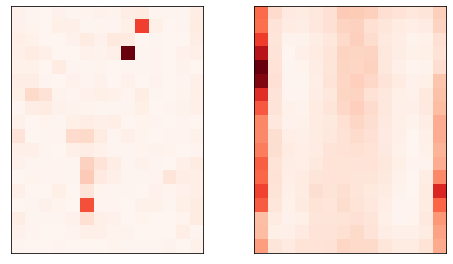

MSE loss = [498.14231305]


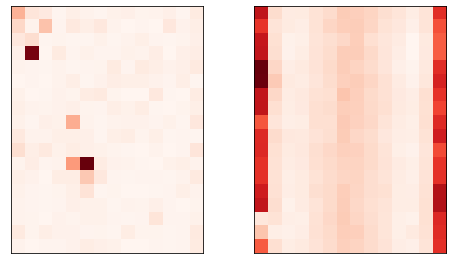

MSE loss = [1248.31403985]


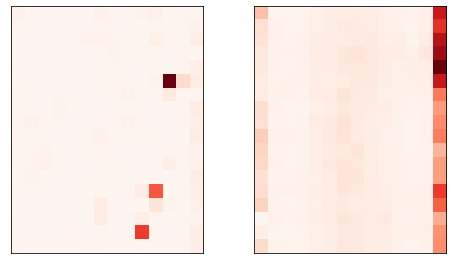

MSE loss = [124.86967777]


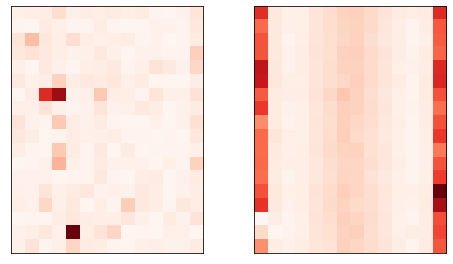

MSE loss = [244.22294611]


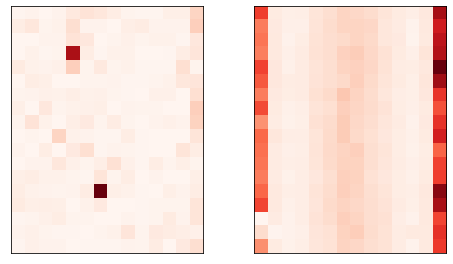

MSE loss = [423.83305966]


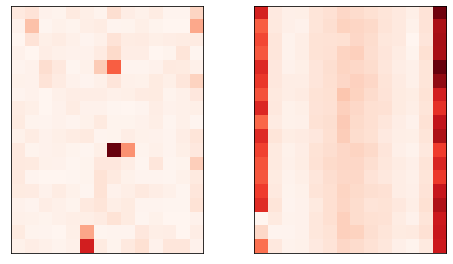

MSE loss = [852.46595334]


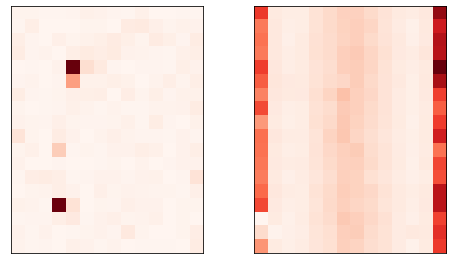

MSE loss = [927.64442059]


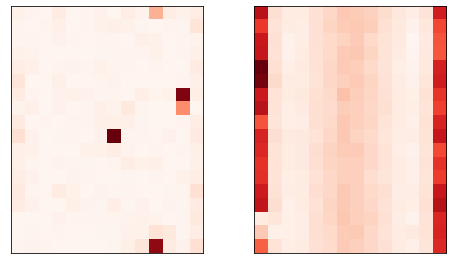

In [40]:
#Original vs Reconstructed for signals test
n = 0
for i in range(100, 110):
    plt.figure(figsize=(8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(signals_overlaid[n][i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(signals_overlaid_predict[n][i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print('MSE loss = ' + str(signals_overlaid_mse[n][i]))
    
    plt.show()

[2703.621]


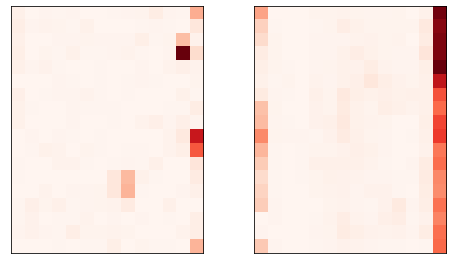

[135.61472]


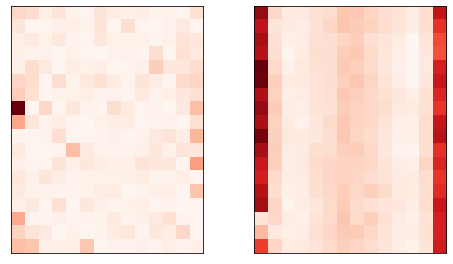

[79.28364]


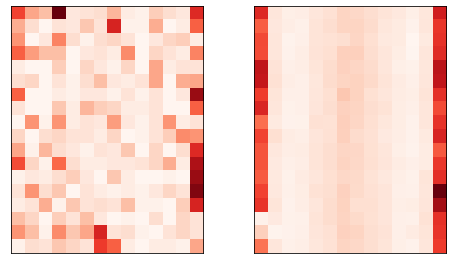

[938.63135]


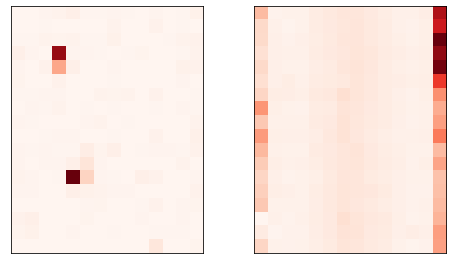

[972.2811]


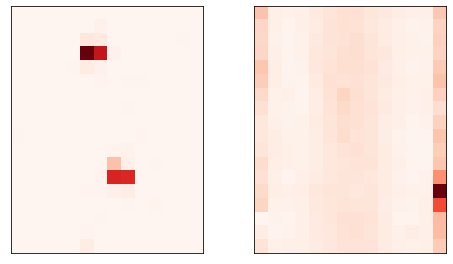

[311.30716]


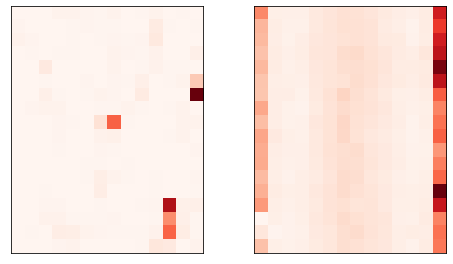

[2526.1543]


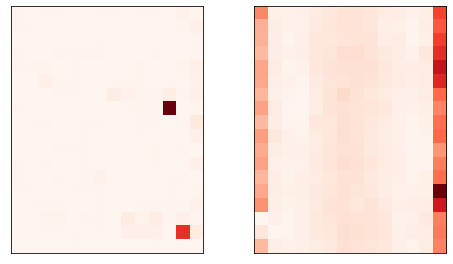

[1236.5908]


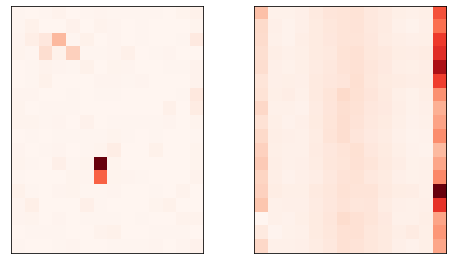

[3161.1714]


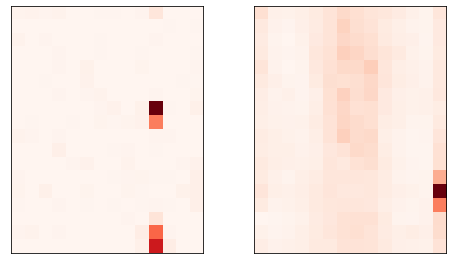

[203.81064]


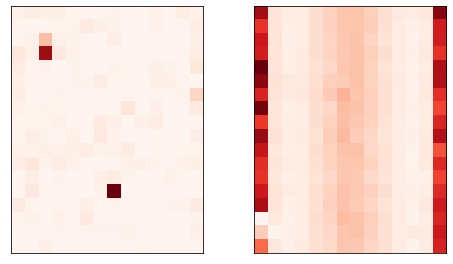

In [41]:
#Original vs Reconstructed for QCD test
for i in range(110,120):
    plt.figure(figsize=(8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(QCD[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(QCD_predict[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(QCD_mse[i])
    
    plt.show()

In [ ]:
#Original vs Reconstructed for SingleNeutrino_E10 test
for i in range(110,120):
    plt.figure(figsize=(8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(SingleNeutrino_E10[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(SingleNeutrino_E10_predict[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(SingleNeutrino_E10_mse[i])
    
    plt.show()

In [ ]:
#Original vs Reconstructed for SingleNeutrino_Pt2To20 test
for i in range(110,120):
    plt.figure(figsize=(8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(SingleNeutrino_Pt2To20[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(SingleNeutrino_Pt2To20_predict[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(SingleNeutrino_Pt2To20_mse[i])
    
    plt.show()

### Plot ROC curves

In [42]:
Y_test_zb = np.zeros((X_test.shape[0], 1))
Y_signals = []
Y_true = []
Y_predict = []
for i in range(len(signals)):
    Y_signals.append(np.ones((signals[i].shape[0], 1)))
    Y_true.append(np.concatenate((Y_signals[i], Y_test_zb)))
    Y_predict.append(np.concatenate((signals_overlaid_mse[i], X_test_mse)))

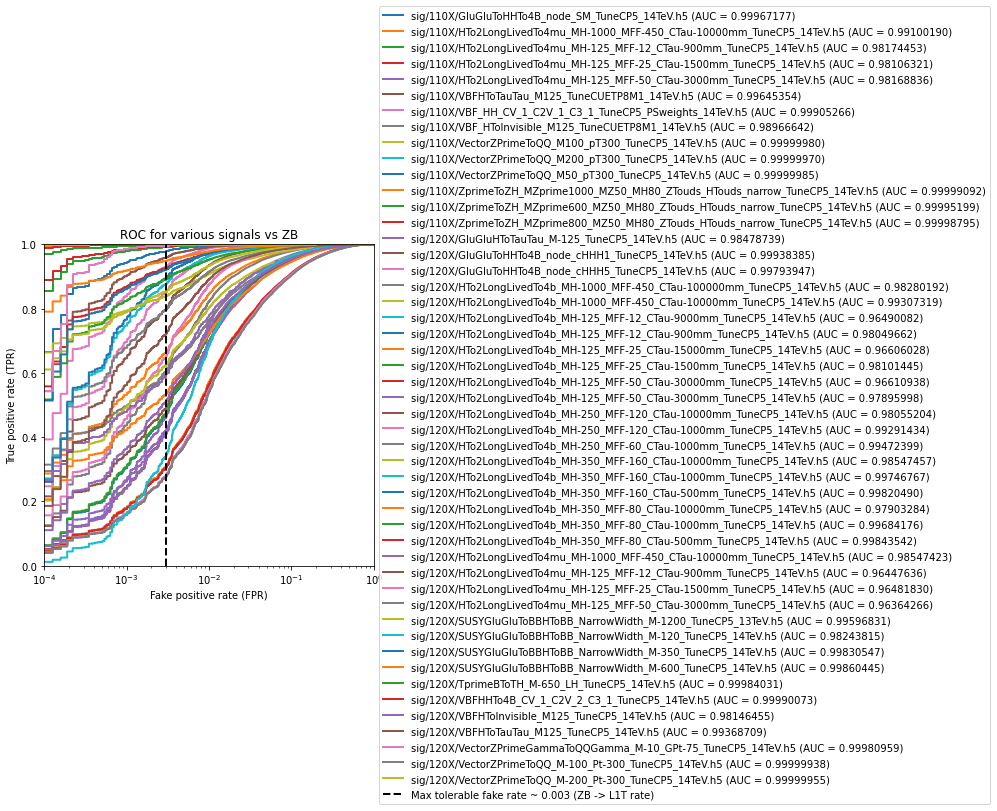

In [43]:
# Plot ROC
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr = []
tpr = []
thresholds = []
roc_auc = []
for i in range(len(signals)):
    fpr.append(np.empty((Y_true[i].shape[0],1)))
    tpr.append(np.empty((Y_true[i].shape[0],1)))
    thresholds.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc.append(np.empty((Y_true[i].shape[0],1)))
    fpr[i], tpr[i], thresholds[i] = roc_curve(Y_true[i], Y_predict[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('ROC for various signals vs ZB')
axes.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.show()

In [44]:
#Split ROC by efficiency range
sig_idx_eff_0to50 = []
sig_idx_eff_50to60 = []
sig_idx_eff_60to70 = []
sig_idx_eff_70to80 = []
sig_idx_eff_80to90 = []
sig_idx_eff_90to95 = []
sig_idx_eff_95to99 = []
sig_idx_eff_99to100 = []

for i in range(len(fpr)):
    for j in range(len(fpr[i])):
        if fpr[i][j] > 0.003:
            if tpr[i][j] > 0.99:
                sig_idx_eff_99to100.append(i)
            elif tpr[i][j] > 0.95:
                sig_idx_eff_95to99.append(i)
            elif tpr[i][j] > 0.9:
                sig_idx_eff_90to95.append(i)
            elif tpr[i][j] > 0.8:
                sig_idx_eff_80to90.append(i)
            elif tpr[i][j] > 0.7:
                sig_idx_eff_70to80.append(i)
            elif tpr[i][j] > 0.6:
                sig_idx_eff_60to70.append(i)
            elif tpr[i][j] > 0.5:
                sig_idx_eff_50to60.append(i)
            else:
                sig_idx_eff_0to50.append(i)
            break
sig_idx_eff_all = []
sig_idx_eff_all.append(sig_idx_eff_0to50)
sig_idx_eff_all.append(sig_idx_eff_50to60)
sig_idx_eff_all.append(sig_idx_eff_60to70)
sig_idx_eff_all.append(sig_idx_eff_70to80)
sig_idx_eff_all.append(sig_idx_eff_80to90)
sig_idx_eff_all.append(sig_idx_eff_90to95)
sig_idx_eff_all.append(sig_idx_eff_95to99)
sig_idx_eff_all.append(sig_idx_eff_99to100)

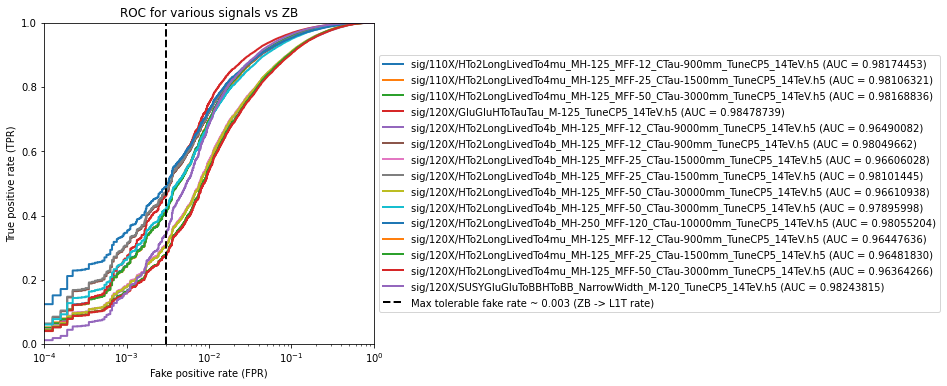

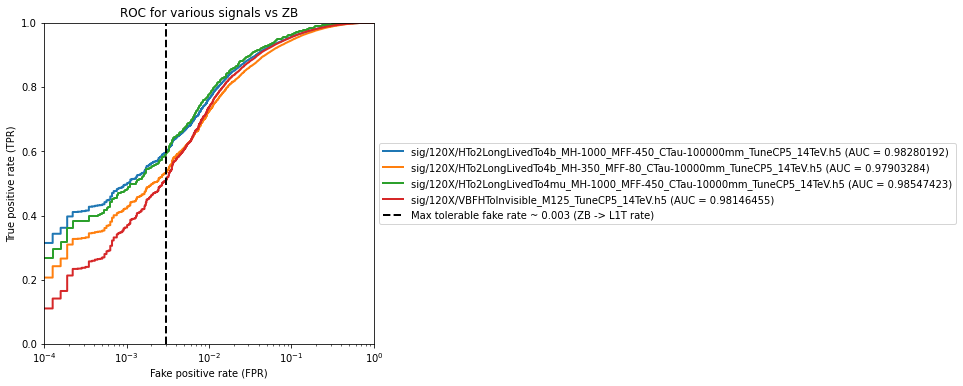

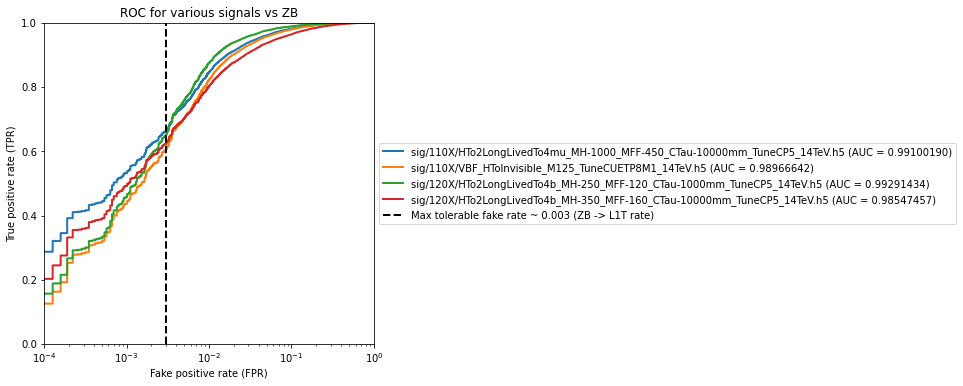

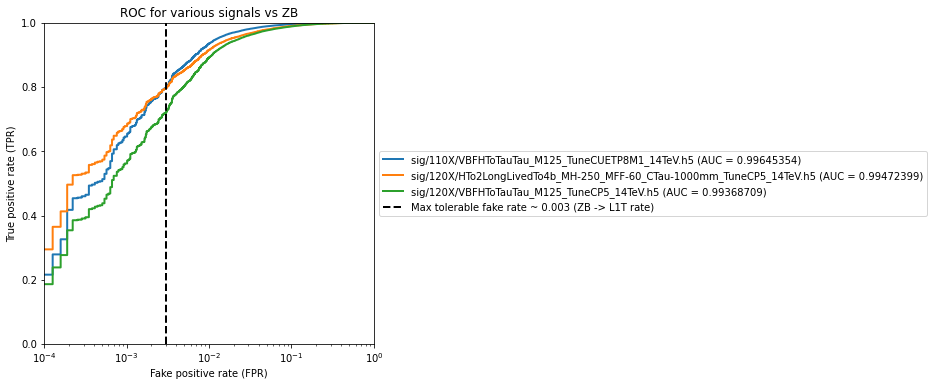

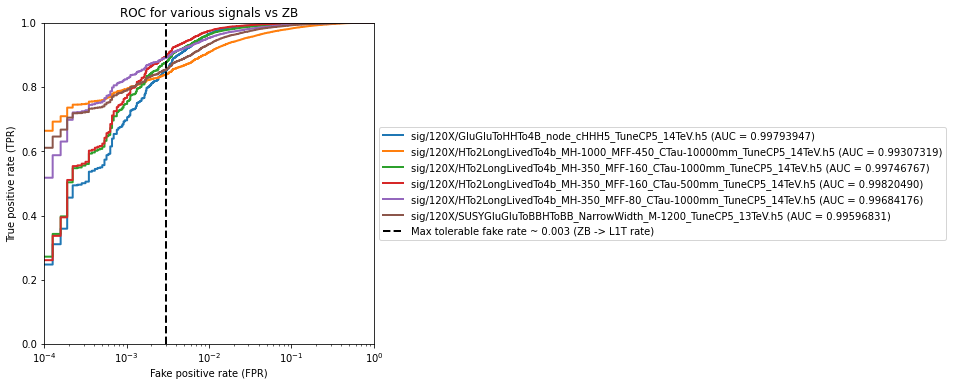

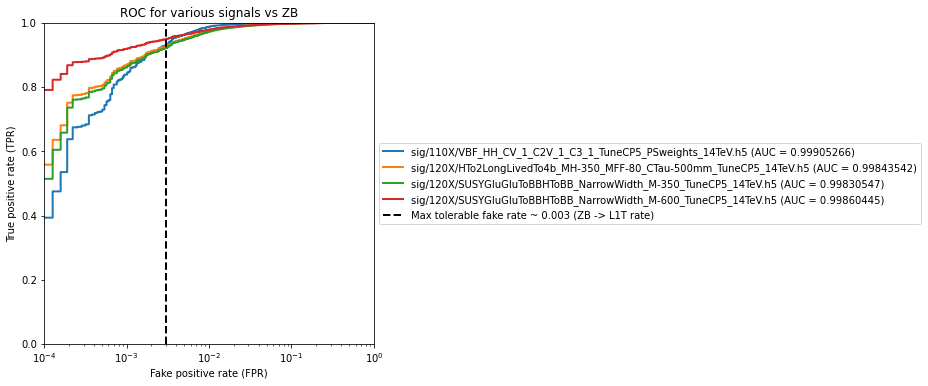

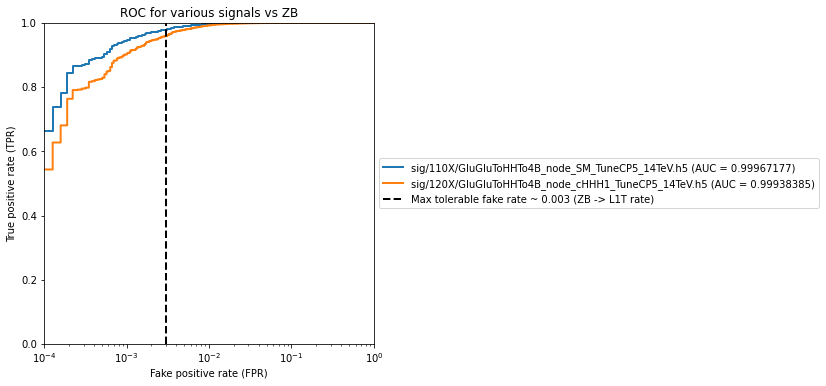

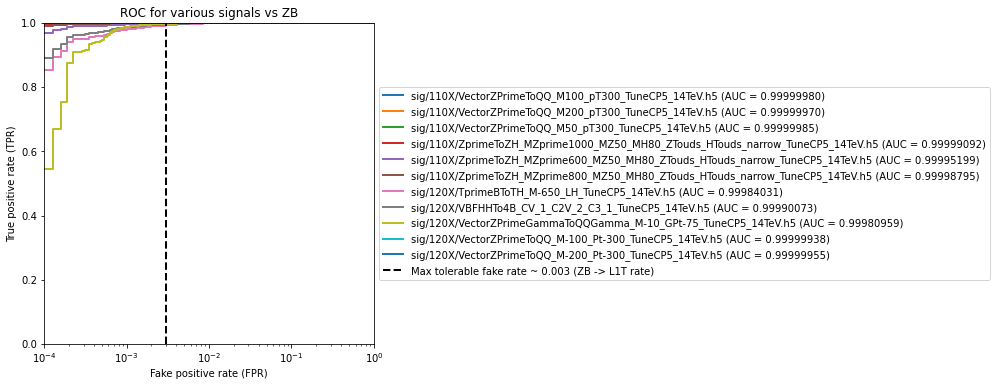

In [46]:
# Plot ROC by efficiency range
for i in range(len(sig_idx_eff_all)):
    plt.figure(figsize = (13, 13))
    axes = plt.subplot(2, 2, 1)
    for j in range(len(sig_idx_eff_all[i])):
        axes.plot(fpr[sig_idx_eff_all[i][j]], tpr[sig_idx_eff_all[i][j]], lw = 2, label = signal_files[sig_idx_eff_all[i][j]] + ' (AUC = %.8f)' % (roc_auc[sig_idx_eff_all[i][j]]))
    #axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
    axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
    axes.set_xlim([0.0001, 1.0])
    #axes.set_xlim([0, 1.0])
    axes.set_ylim([0, 1.0])
    #axes.set_ylim([0.9, 1.0])
    axes.set_xscale(value = "log")
    #axes.set_yscale(value = "log")
    axes.set_xlabel('Fake positive rate (FPR)')
    axes.set_ylabel('True positive rate (TPR)')
    axes.set_title('ROC for various signals vs ZB')
    axes.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    plt.show()

### Plot 2D latent space

In [47]:
X_train_encoded = encoder.predict(X_train, batch_size = 1024)
X_test_encoded = encoder.predict(X_test, batch_size = 1024)
signals_overlaid_encoded = encoder.predict(signals_overlaid[0], batch_size = 1024)

2022-03-30 18:19:18.431182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


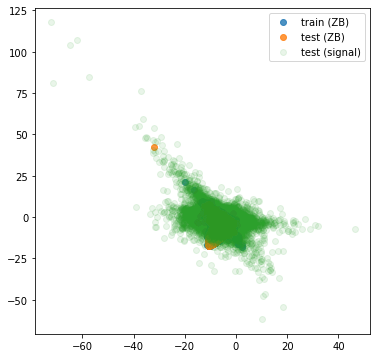

In [61]:
i = 1
j = 2
plt.figure(figsize=(6, 6))
plt.scatter(X_train_encoded[:, i], X_train_encoded[:, j], alpha = 0.8, label = 'train (ZB)')
plt.scatter(X_test_encoded[:, i], X_test_encoded[:, j], alpha = 0.8, label = 'test (ZB)')
plt.scatter(signals_overlaid_encoded[:, i], signals_overlaid_encoded[:, j], alpha = 0.1, label = 'test (signal)')
plt.legend()
#plt.colorbar()
plt.show()